<a href="https://colab.research.google.com/github/GustavoFRS/Blog/blob/main/huskylobo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
 
from tensorflow import keras

# Evitando erros de memória

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# Remoção de imagens

In [ ]:
import cv2
import imghdr

data_dir = 'drive/MyDrive/learning_datasets'
extensions = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in extensions:
        print(f'Image not in extensions list {image_path}')
        os.remove(image_path)
    except Exception as e:
      print(f'Issue with image {image_path}')

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('drive/MyDrive/learning_datasets')

Found 228 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
# batch[0].shape = (batch_size, width, height, channels)
# batch[1] = [0, 1, 1, 0 ...] -> labels de 0 até n classes

In [ ]:
# Classe 0 = Husky
# Classe 1 = Lobo
batch[1]

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1], dtype=int32)

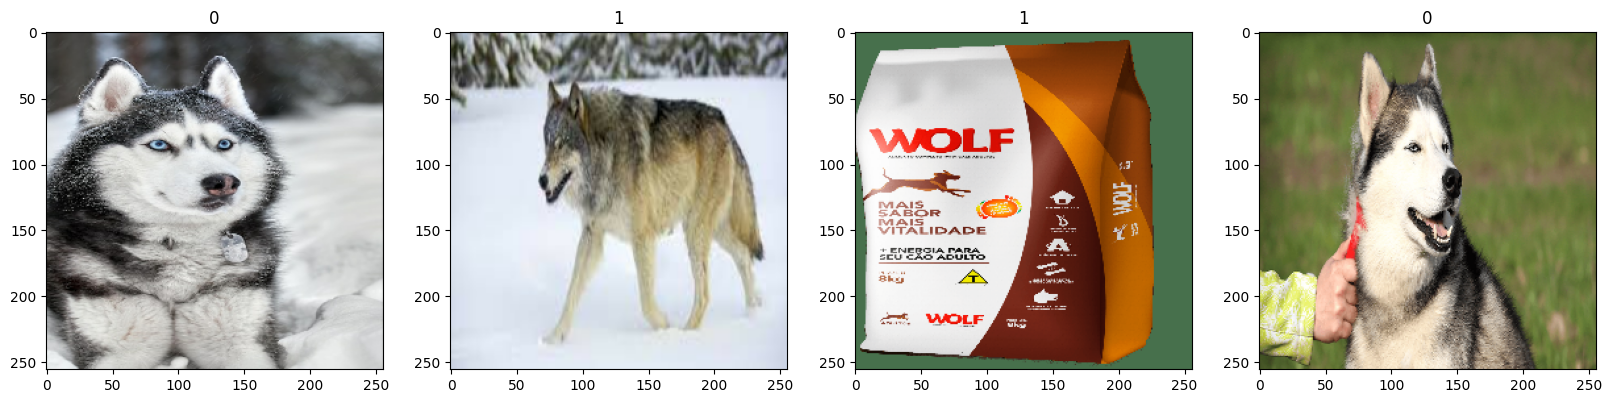

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

# Preprocessamento
#### Mudando o range de 0-255 para 0-1

In [ ]:
data = data.map(lambda x, y: (x/255, y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

In [ ]:
print(f'Mínimo: {batch[0].min()}, Máximo: {batch[0].max()}')

1.0

# Divisão de dados

In [ ]:
train_size = int(len(data)*0.7)+1
val_size = int(len(data)*0.15)
test_size = int(len(data)*0.15)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Criando o modelo

In [ ]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential, load_model

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # 1 represents a single output, 0 or 1 due to the sigmoid nature

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Treino

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 19s 785ms/step - loss: 1.1475 - accuracy: 0.4219 - val_loss: 0.7197 - val_accuracy: 0.4688
Epoch 2/20
6/6 [==============================] - 6s 605ms/step - loss: 0.6993 - accuracy: 0.4896 - val_loss: 0.6802 - val_accuracy: 0.5312
Epoch 3/20
6/6 [==============================] - 7s 888ms/step - loss: 0.6942 - accuracy: 0.5365 - val_loss: 0.6199 - val_accuracy: 0.5938
Epoch 4/20
6/6 [==============================] - 6s 626ms/step - loss: 0.6401 - accuracy: 0.7552 - val_loss: 0.6217 - val_accuracy: 0.8438
Epoch 5/20
6/6 [==============================] - 7s 621ms/step - loss: 0.5651 - accuracy: 0.7552 - val_loss: 0.5752 - val_accuracy: 0.5938
Epoch 6/20
6/6 [==============================] - 8s 1s/step - loss: 0.4579 - accuracy: 0.7708 - val_loss: 0.3635 - val_accuracy: 0.9062
Epoch 7/20
6/6 [==============================] - 6s 612ms/step - loss: 0.3454 - accuracy: 0.8854 - val_loss: 0.2749 - val_accuracy: 0.9062
Epoch 8/20
6/6 [======

3.3 Plot Performance

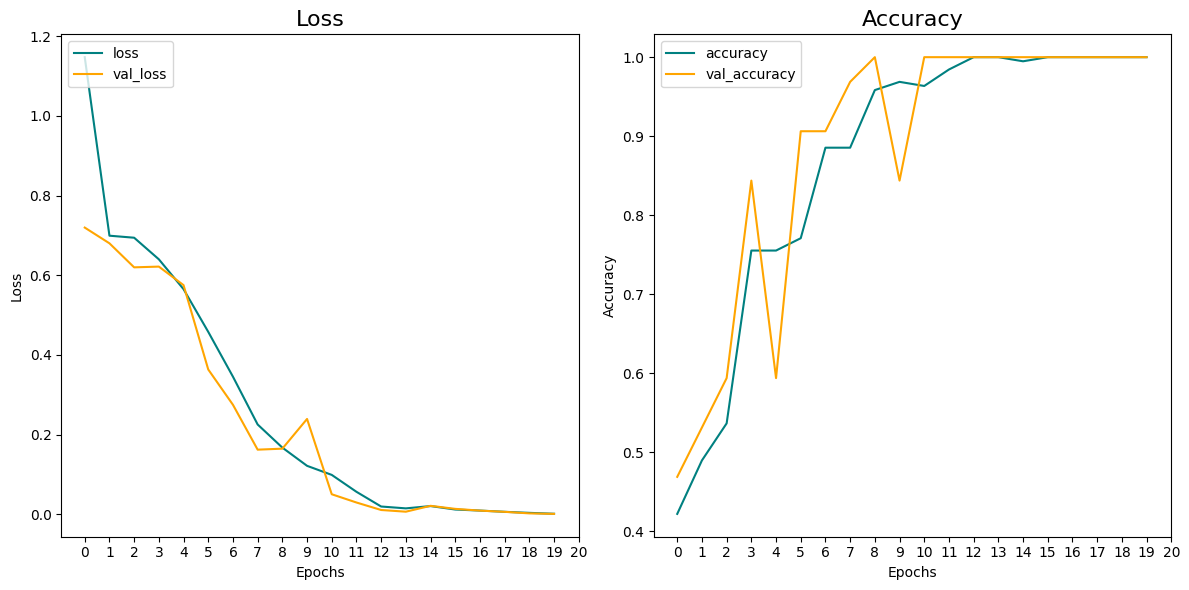

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot de Loss
ax1.plot(hist.history['loss'], color='teal', label='loss')
ax1.plot(hist.history['val_loss'], color='orange', label='val_loss')
ax1.set_title('Loss', fontsize=16)
ax1.set_xlabel('Epochs')
ax1.set_xticks(range(21))
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# Plot de Accuracy
ax2.plot(hist.history['accuracy'], color='teal', label='accuracy')
ax2.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax2.set_title('Accuracy', fontsize=16)
ax2.set_xlabel('Epochs')
ax2.set_xticks(range(21))
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


Evaluate

In [ ]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
precision = Precision()
recall = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 254ms/step


In [ ]:
print(f'Precision:{precision.result()}, Recall:{recall.result()}, Accuracy:{acc.result()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


# Teste com imagem de fora do dataset

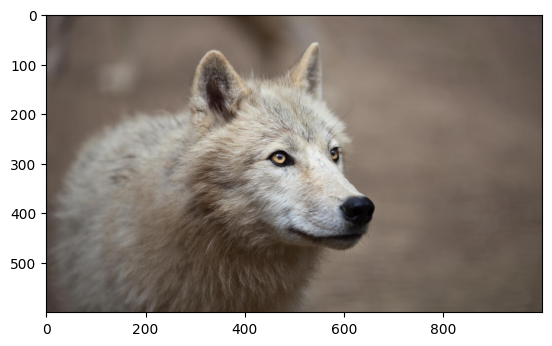

In [36]:
img = cv2.imread('/content/drive/MyDrive/learning_datasets/wolftest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [39]:
resized_image = tf.image.resize(img, (256,256))

In [40]:
np.expand_dims(resized_image, 0).shape

(1, 256, 256, 3)

In [41]:
yhat = model.predict(np.expand_dims(resized_image/255, 0))

1/1 [==============================] - 0s 123ms/step


In [43]:
if yhat > 0.5:
  print('A classe prevista é: Lobo')
else:
  print('A classe prevista é: Husky')

Predicted class is Wolf


# Salvar o modelo

In [44]:
from keras.models import load_model

model.save(os.path.join('drive/MyDrive/Models', 'huskyorwolf.h5'))
